In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
from sklearn.decomposition import PCA
import itertools
import matplotlib.patches as mpatches
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import SpectralClustering
import umap
import bbknn
import bbknn.matrix
from importlib import reload
from scipy import stats
import gget

# locals
import utils as ut
reload(ut)

2023-02-15 15:46:16.946645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 15:46:17.062131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-02-15 15:46:17.062155: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 15:46:17.087808: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-15 15:46:17.9979

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [3]:
rna['ND'].head()

Unnamed: 0,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
cellId,,,,,,,,,,,,,,,,,,,,,
AAACGAACAGCAGTAG.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAAGAACGTCTACAGT.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
AAAGAACTCCTCGCAT.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0
AAAGGGCGTTAGGGTG.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AACAAAGAGTATAGGT.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
rdf = [] # rna dataframe
refs = [] # label dataframe

keys = ['ND', 'HFD8', 'HFD14']

ctypes = [
    'Monocytes', 
    'Mac1', 
    'Mac2', 
    'Mac3', 
    'Mac4', 
    'Mac5', 
]

for key in keys:
    rf = rna[key].copy()
    lf = labels[key]
    
    labelMask = (lf['cellType'].isin(ctypes))
    
    # add key flags to barcodes 
    mf = lf[labelMask].reset_index(drop=True)
    mf['cellId'] = mf['cellId'] + "_" + key
    
    rf.index = rf.index + "_" + key
    
    # filter out non-myleiod cells
    rf = rf[rf.index.isin(mf['cellId'])]
    
    rdf.append(rf)
    refs.append(mf)
    
    print(key, mf.shape, rf.shape)

    
print()
rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf = rdf.sort_values('cellId')
rdf.head()

# need to re-index
refs = pd.concat(refs)
print(f"{refs.shape=}")
refs = refs[refs['cellId'].isin(rdf.index)]
refs = refs.drop_duplicates(subset='cellId')
refs = refs.sort_values('cellId')

print(f"{refs.shape=}")
refs.head()

ND (536, 6) (534, 31053)
HFD8 (2909, 6) (2902, 31053)
HFD14 (4903, 6) (4893, 31053)

rdf.shape=(8329, 31053)
refs.shape=(8348, 6)
refs.shape=(8329, 6)


,cellId,cellType,sampleInfo,x,y,colors
0,AAACCCAAGACTTCAC.1_HFD14,Mac5,HFD14,-0.587754,-0.134421,#fdbf6f
1,AAACCCAAGCAACAAT.1_HFD14,Mac5,HFD14,-1.347843,-0.644214,#fdbf6f
0,AAACCCACACAAAGCG.1_HFD8,Mac4,HFD8,-0.985782,2.308999,#fdbf6f
2,AAACCCAGTAGCACAG.1_HFD14,Monocytes,HFD14,2.248105,4.033276,#ffffbe
3,AAACCCAGTTACCTGA.1_HFD14,Mac4,HFD14,-1.012436,1.498442,#fdbf6f


In [5]:
def getDistanceMatrix(X, r=15, metric='euclidean', returnExp=True):
    """A function to compute pairwise distances from scRNA data """    
    # compute the PCA 
    pca = PCA(n_components=r)
    pcaModel = pca.fit(X)
    Xpca = pca.fit_transform(X)
    
    # compute pairwise similarity
    A = metrics.pairwise_distances(Xpca, metric=metric)
    
    if returnExp:
        exVar = pcaModel.explained_variance_ratio_
        return A, exVar
    else:
        return A

Removed 13850 Genes with STD < 1e-06
Retained: 17203


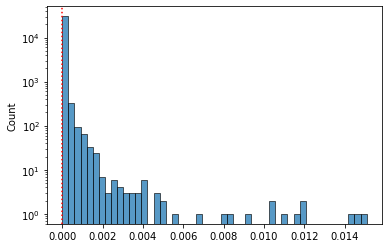

In [6]:
"""
Prepare the data 
"""
geneVarThresh = 0.000001

# a little clean-up on the merged dataframes
Xdf = rdf.copy()
Xdf = Xdf.fillna(0)

# normalize the data
Xdf = ut.normalize(Xdf)

# remove low variance genes
stdT = 0.2
geneStd = Xdf.std(axis=0)

mask = geneStd < geneVarThresh
totalG = len(Xdf.columns)
Xdf = Xdf[Xdf.columns[~mask]]
g = Xdf.shape[1]
print(f"Removed {totalG - g} Genes with STD < {geneVarThresh}")
print(f"Retained: {g}")

sns.histplot(data=geneStd, 
             bins=50)

plt.axvline(x=geneVarThresh, c='r', ls=":")

plt.yscale('log')

In [7]:
"""
Construct the distance matrix 
"""
metric='correlation'
r = 200

X = Xdf.to_numpy()
print(f"{X.shape=}")

A, exVar = getDistanceMatrix(X, r=r, metric=metric)
print(f"{np.sum(exVar)*100=:.4f}% {exVar[:5]}")

# convert distance to similarity
Ahat = A.copy()
Ahat *= 1.0/Ahat.max() 
Ahat = 1 - Ahat 

""" Construct the KNN graph"""
k = 7
knn = kneighbors_graph(Ahat, k)
x, y = np.nonzero(knn.todense())
Aknn = np.zeros(Ahat.shape)

Aknn[x, y] = Ahat[x, y]
print(f"{Aknn.shape=}")

X.shape=(8329, 17203)
np.sum(exVar)*100=93.7820% [0.30371498 0.13594419 0.07629468 0.0698865  0.05127175]
Aknn.shape=(8329, 8329)


In [8]:
""" recluster the cells using spectral """
k = 8

spect = SpectralClustering(n_clusters=k,
                           affinity='precomputed',
                           assign_labels='discretize',
                           random_state=0).fit(Aknn)

refs['cluster'] = spect.labels_
refs['cluster'] = refs['cluster'] + 1

t = refs[['cluster', 'sampleInfo']].value_counts(normalize=True).reset_index()
print(refs[['cluster']].value_counts())

cluster
4          1844
1          1325
7          1267
8          1028
2           902
3           842
5           624
6           497
dtype: int64


In [9]:
refs['metaCell'] = np.where(refs['cellType'] != 'Monocytes', "Macrophages", "Monocytes")
# refs.head()
refs[['cluster', 'metaCell']].value_counts()

cluster  metaCell   
4        Macrophages    1789
1        Macrophages    1314
7        Macrophages    1118
8        Macrophages     822
3        Macrophages     598
2        Monocytes       560
5        Monocytes       408
2        Macrophages     342
6        Monocytes       265
3        Monocytes       244
6        Macrophages     232
5        Macrophages     216
8        Monocytes       206
7        Monocytes       149
4        Monocytes        55
1        Monocytes        11
dtype: int64

In [10]:
t = refs[['cluster', 'sampleInfo']].value_counts().reset_index()
t = t[t['cluster'] == 2]
t[0] = t[0] / t[0].sum()
t

,cluster,sampleInfo,0
5,2,HFD8,0.501109
6,2,HFD14,0.452328
19,2,ND,0.046563


<AxesSubplot: xlabel='x', ylabel='y'>

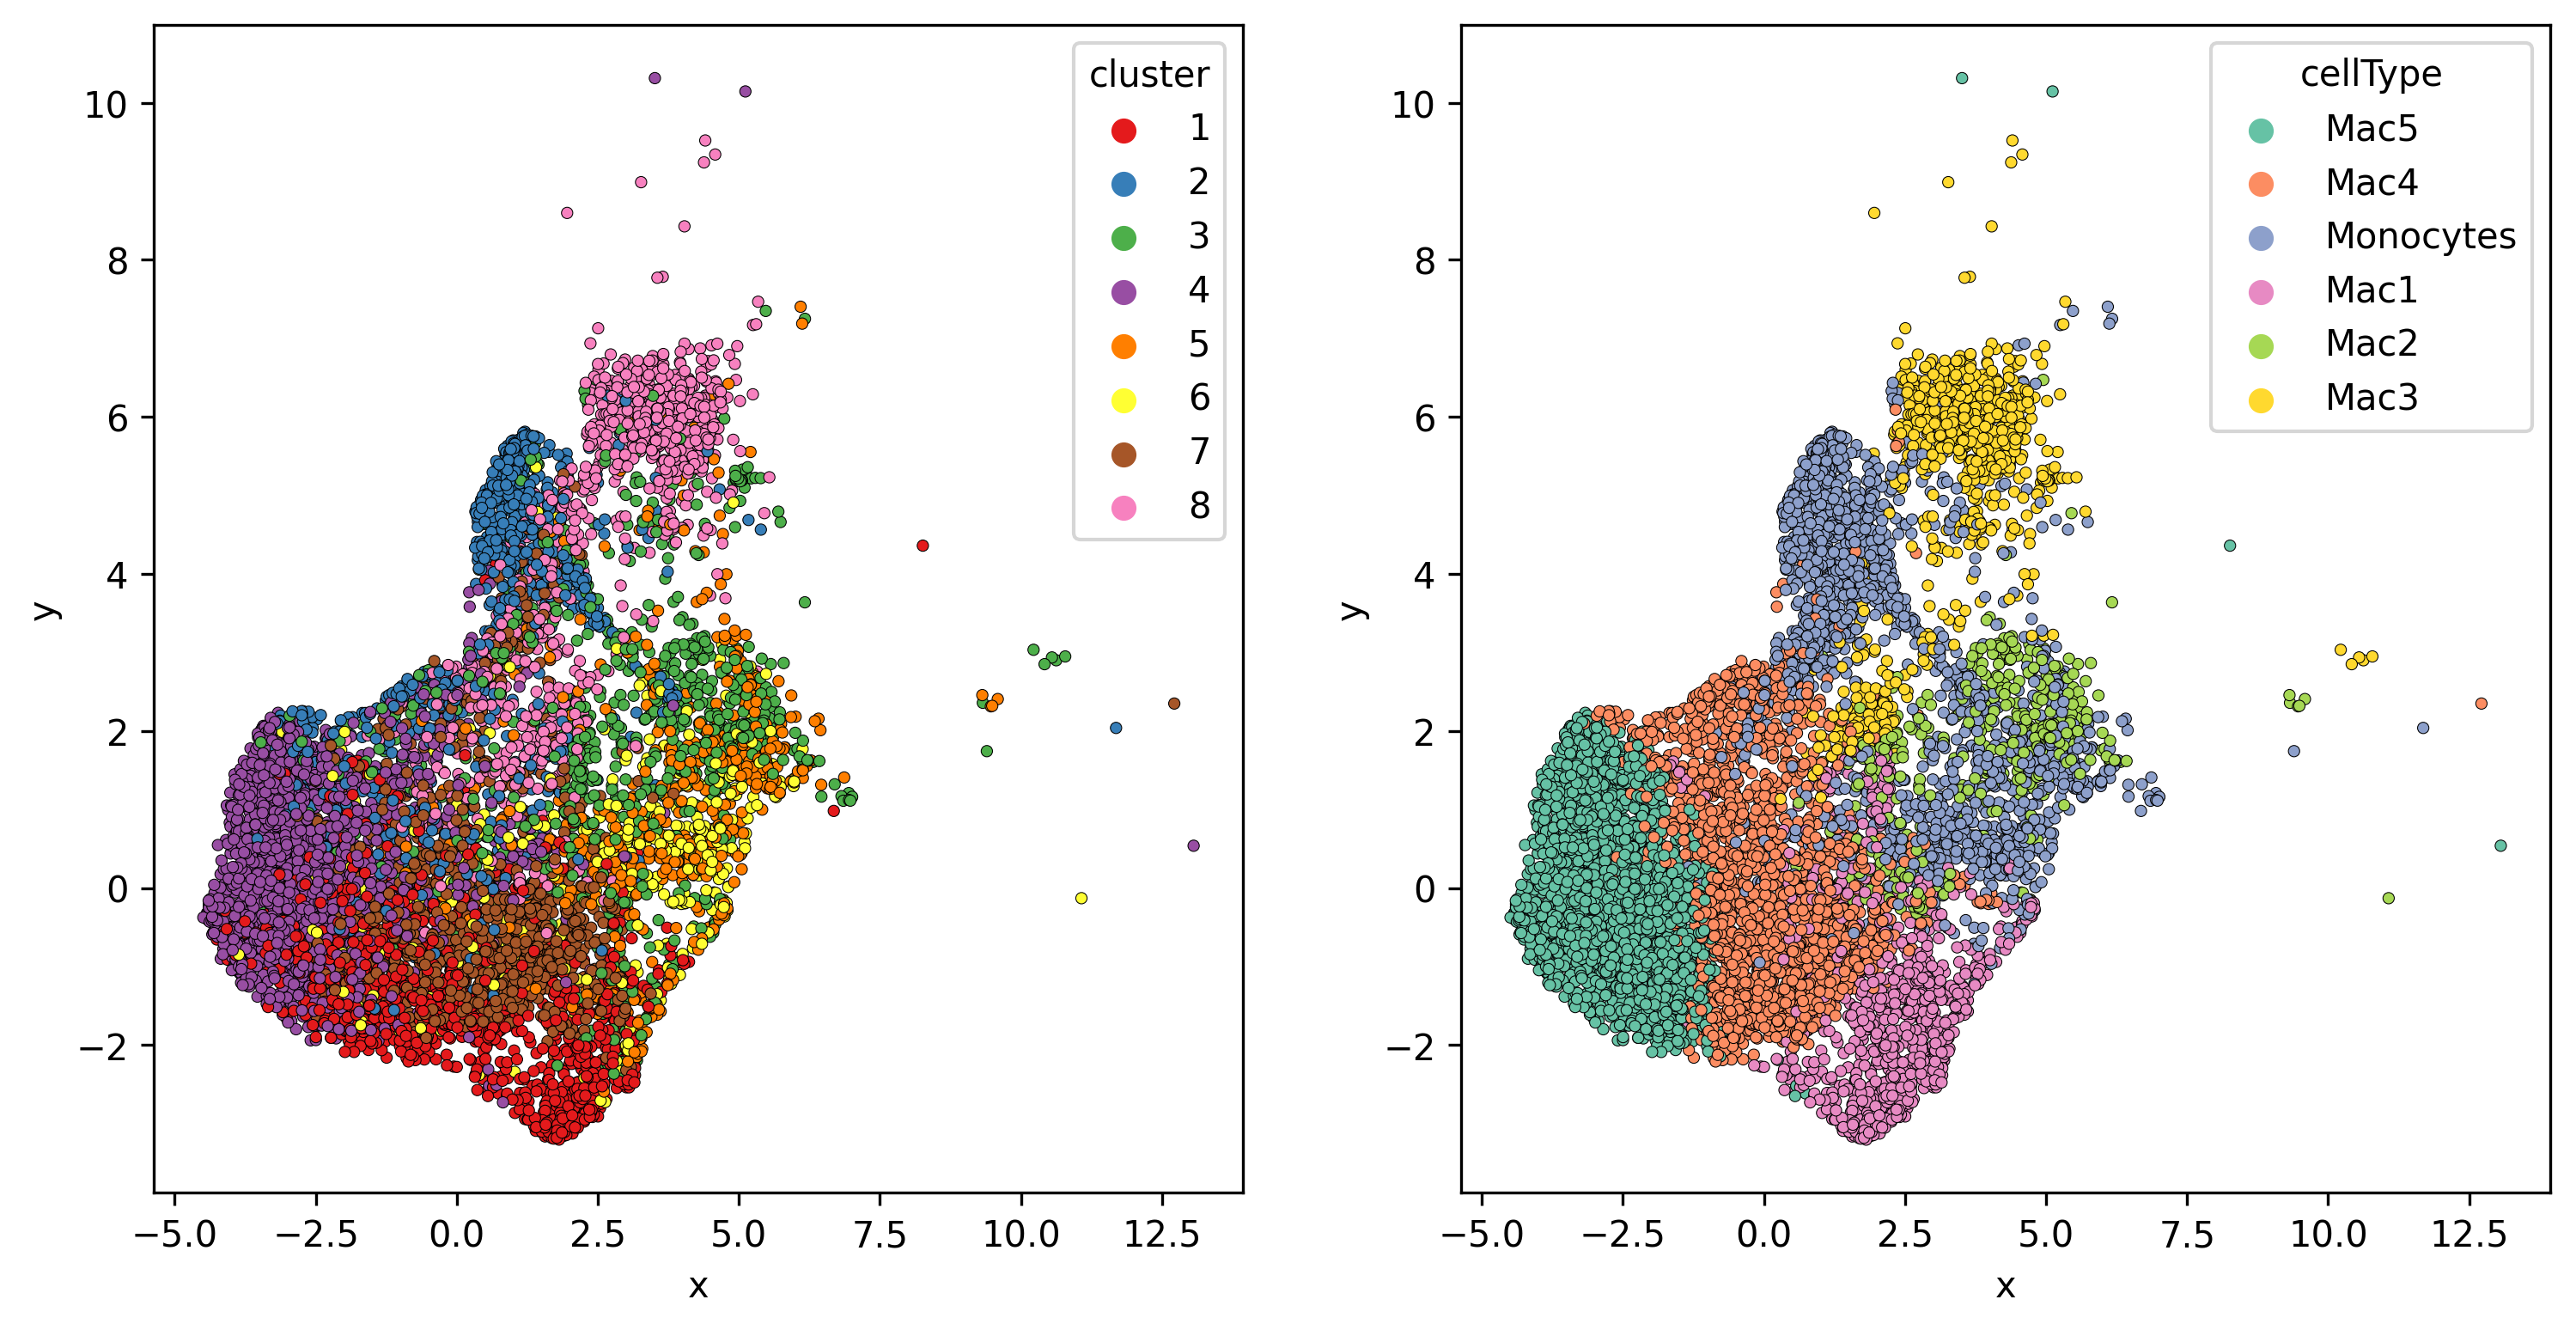

In [11]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 6

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()


sns.scatterplot(data=refs, 
                x='x', 
                y='y', 
                hue='cluster', 
                edgecolor='k',
                linewidths=0.1, 
                s=10,
                palette='Set1',
                ax=axs[0])


sns.scatterplot(data=refs, 
                x='x', 
                y='y', 
                hue='cellType', 
                edgecolor='k',
                linewidths=0.1, 
                s=10,
                palette='Set2',
                ax=axs[1])

In [12]:
sf = refs.copy()
sf = sf.reset_index(drop=True)
sf['cellId'] = sf['cellId'].apply(lambda x: str(x).split("_")[0].replace(".", "-"))
sf = sf[['cellId', 'cellType', 'sampleInfo', 'x', 'y', 'cluster']]

outpath = "~/temp/macMono.csv"
sf.to_csv(outpath, index=False)

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
 plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 4, 4

# pdf = embedding.copy()
# pdf['Cluster'] = refs['Spectral'].to_list() 
# pdf['Cluster'] = pdf['Cluster'] + 1

# subtypes = {
#     1 : 'Mac5',
#     2 : 'Mac1',
#     3 : 'Mac3',
#     4 : 'Mac2',
#     5 : 'Mac4',
# }

# pdf['Subtype'] = pdf['Cluster'].map(subtypes)
# pdf = pdf.sort_values(by='Subtype')

# colors = [
#     '#9835e4',
#     '#e48035',
#     '#8e0152',
#     '#9acd61',
#     '#276419',
# ]

# sns.scatterplot(data=pdf,
#                 x='x',
#                 y='y',
#                 marker=".",
#                 s=30,
#                 alpha=0.8,
#                 linewidth=0.15,
#                 hue='Subtype',
#                 edgecolor='k',
#                 palette=colors)

# _ = plt.xticks([], [])
# _ = plt.yticks([], [])
# plt.ylabel("UMAP 2")
# plt.xlabel("UMAP 1")
    
# plt.legend(bbox_to_anchor=(1.04, 1.02))

In [ ]:
""" recluster the cells using spectral """
k = 5

spect = SpectralClustering(n_clusters=k,
                           affinity='precomputed',
                           assign_labels='discretize',
                           random_state=0).fit(Aknn)

refs['Spectral'] = spect.labels_
print(refs['Spectral'].value_counts())

for cid in refs['Spectral'].unique():
        cluster = refs[refs['Spectral'] == cid]
        print(f"==== {cid+1} n={len(cluster)}===")
        print(cluster['key'].value_counts(normalize=True))
        print()
        
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

pdf = embedding.copy()
pdf['Cluster'] = refs['Spectral'].to_list() 
pdf['Cluster'] = pdf['Cluster'] + 1

subtypes = {
    1 : 'Mac5',
    2 : 'Mac1',
    3 : 'Mac3',
    4 : 'Mac2',
    5 : 'Mac4',
}

pdf['Subtype'] = pdf['Cluster'].map(subtypes)
pdf = pdf.sort_values(by='Subtype')

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

sns.scatterplot(data=pdf,
                x='x',
                y='y',
                marker=".",
                s=30,
                alpha=0.8,
                linewidth=0.15,
                hue='Subtype',
                edgecolor='k',
                palette=colors)

_ = plt.xticks([], [])
_ = plt.yticks([], [])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
    
plt.legend(bbox_to_anchor=(1.04, 1.02))

In [ ]:
q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)
q = q.sort_values(by='Subtype')

colorMap = dict(zip(q['Subtype'].unique(), colors))
q['color'] = q['Subtype'].map(colorMap)

q = pd.pivot_table(q, 
                   values='CellId', 
                   index=['Subtype'], 
                   columns='key',
                   aggfunc='count')

keys = ['ND', 'HFD8', 'HFD14']
q = q[keys] # column order

for k in keys:
    q[k] = q[k] / q[k].sum()

q.T.plot(kind='bar', 
         stacked=True, 
         edgecolor='k',
         color=colors)
    
plt.legend(bbox_to_anchor=(1.05, 1.025))
plt.ylabel('Proportion of Macrophages')
_ = plt.xticks(rotation=0)
plt.xlabel("")
# plt.title("Macrophages")  

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 2

q = refs.copy()
q['Cluster'] = q['Spectral'] + 1
q['Subtype'] = q['Cluster'].map(subtypes)

q = pd.DataFrame(q[['Subtype', 'key']].value_counts()).reset_index()
q = q.sort_values(by=['key', 'Subtype'])
q.columns = ['subtype', 'time', 'cell count']

# in grams
weights = {
    'ND' : 1.079,
    'HFD8' : 6.573,
    'HFD14' : 4.412,
}

q['weight'] = q['time'].map(weights)
q['cells per gram'] = q['cell count'] / q['weight'] 

q = q.sort_values(by=['time', 'subtype'], ascending=[False, True])


sns.barplot(data=q, 
            x='time', 
            y='cells per gram', 
            edgecolor='k',
            hue='subtype', 
            palette=colors)

plt.ylabel('Cells/Gram')
plt.xlabel('')
plt.legend([],[], frameon=False)
# legend = plt.gca().legend(bbox_to_anchor=(1.04, 1.02))
# plt.gca().invert_xaxis()

In [ ]:
break

In [ ]:
# """Save the clustering results """
# outpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/macrophageSubtypes.csv"

# sf = refs.copy()
# sf = sf[['CellId', 'key', 'Spectral', 'ctype']]
# sf.columns = ['cellId', 'key', 'clusterId', 'cellType']
# sf['clusterId'] = sf['clusterId'] + 1
# sf['subtypeId'] = sf['clusterId'].map(subtypes)
# sf.to_csv(outpath, index=False)
# sf.head()

In [ ]:
# sf = refs.copy()
# pdf = embedding.copy()

# sf = sf[['CellId', 'key', 'Spectral']]
# sf['clusterId'] = sf['Spectral'] + 1
# sf['subtypeId'] = sf['clusterId'].map(subtypes)
# sf['UMAP X'] = pdf['x']
# sf['UMAP Y'] = pdf['y']

# cidMap = {
#     "Mac1" : "ATM",
#     "Mac2" : "Activated 1",
#     "Mac3" : "Activated 2",
#     "Mac4" : "LAM 2",
#     "Mac5" : "LAM 1",
# }
# sf['Label'] = sf['subtypeId'].map(cidMap)
# sf = sf[['CellId', 'key', 'clusterId', 'subtypeId', 'UMAP X', 'UMAP Y', 'Label']]
# outpath = "~/temp/macrophageSubtypeClassification.csv"
# sf.to_csv(outpath, index=False)
# sf.head()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4


query = 'Itgax'
query = query.upper()

queryVec = res[query].to_numpy()
queryVec *= (1.0/queryVec.max())

y_pred = np.where(queryVec > 0, 1, 0)

plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=30,
            edgecolor='k',
            lw=0.1,
            cmap='viridis',
            c=queryVec,
            alpha=0.8)

# plt.colorbar(label='Expression')
_ = plt.xticks([], [])
_ = plt.yticks([], [])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title("Cd11c")
# plt.title(str(query).lower().capitalize())

for c in  refs['Spectral'].unique():
    y_true = np.where(refs['Spectral'] == c, 1, 0)
    print(f"==== Cluster {c+1} {query} ====")
    # print(metrics.classification_report(y_true, y_pred))
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    print(f"\t{precision=:.4f}")
    print(f"\t{accuracy=:.4f}")
    

In [ ]:
break